In [37]:
import pandas as pd

import matplotlib
matplotlib.rcParams["axes.facecolor"] = 'whitesmoke'
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sb

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse


In [38]:
## load data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.head()

ID             datetime  temperature  var1  pressure  windspeed var2  \
0   0  2013-07-01 00:00:00        -11.4 -17.1    1003.0    571.910    A   
1   1  2013-07-01 01:00:00        -12.1 -19.3     996.0    575.040    A   
2   2  2013-07-01 02:00:00        -12.9 -20.0    1000.0    578.435    A   
3   3  2013-07-01 03:00:00        -11.4 -17.1     995.0    582.580    A   
4   4  2013-07-01 04:00:00        -11.4 -19.3    1005.0    586.600    A   

   electricity_consumption  
0                    216.0  
1                    210.0  
2                    225.0  
3                    216.0  
4                    222.0

In [39]:
## check summary statistics train data
train.loc[:, train.columns != 'ID'].describe()

temperature          var1      pressure     windspeed  \
count  26496.000000  26496.000000  26496.000000  26496.000000   
mean       5.098989     -1.916233    986.450615     23.959956   
std        8.682860     10.424860     12.002647     48.280321   
min      -17.100000    -32.900000    953.000000      1.075000   
25%       -2.900000    -10.700000    978.000000      3.155000   
50%        6.400000     -1.400000    986.000000      6.545000   
75%       12.100000      7.900000    995.000000     22.260000   
max       23.600000     18.600000   1024.000000    586.600000   

       electricity_consumption  
count             26496.000000  
mean                298.359601  
std                 108.020555  
min                 174.000000  
25%                 219.000000  
50%                 267.000000  
75%                 342.000000  
max                1386.000000

In [40]:
## check summary statistics test data
test.loc[:, test.columns != 'ID'].describe()

temperature         var1     pressure    windspeed
count  8568.000000  8568.000000  8568.000000  8568.000000
mean      5.112757    -1.726401   986.329599    24.176398
std       8.606167    10.345034    12.148517    49.651535
min     -17.900000   -26.400000   954.000000     1.075000
25%      -2.100000   -10.000000   977.000000     3.155000
50%       5.700000    -2.100000   987.000000     6.295000
75%      12.100000     7.900000   995.000000    21.907500
max      25.700000    17.900000  1023.000000   491.255000

Text(0.5, 1.0, 'var2')

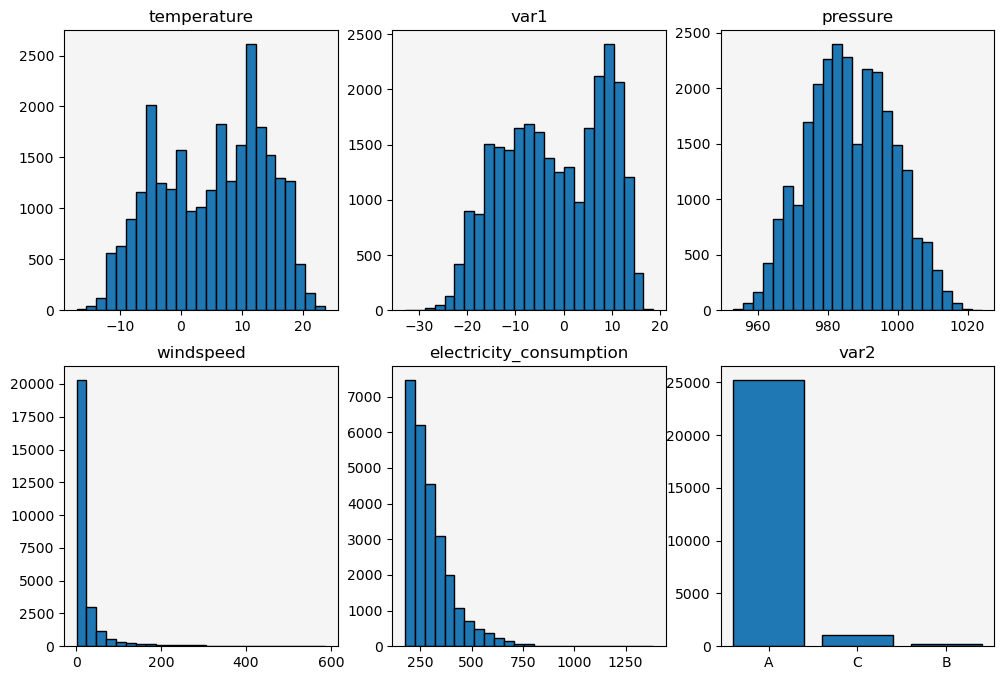

In [41]:
## inspect histograms of train column data
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
cols = ['temperature','var1','pressure','windspeed','electricity_consumption']
for i in range(0,len(cols)):
    axs[i//3,i-3*(i//3)].hist(train[cols[i]],bins=25,edgecolor='black')
    axs[i//3,i-3*(i//3)].set_title(cols[i])
categories = train['var2'].value_counts().index
counts = train['var2'].value_counts().values
axs[1,2].bar(categories, counts, edgecolor='black')
axs[1,2].set_title('var2')

Text(0.5, 1.0, 'var2')

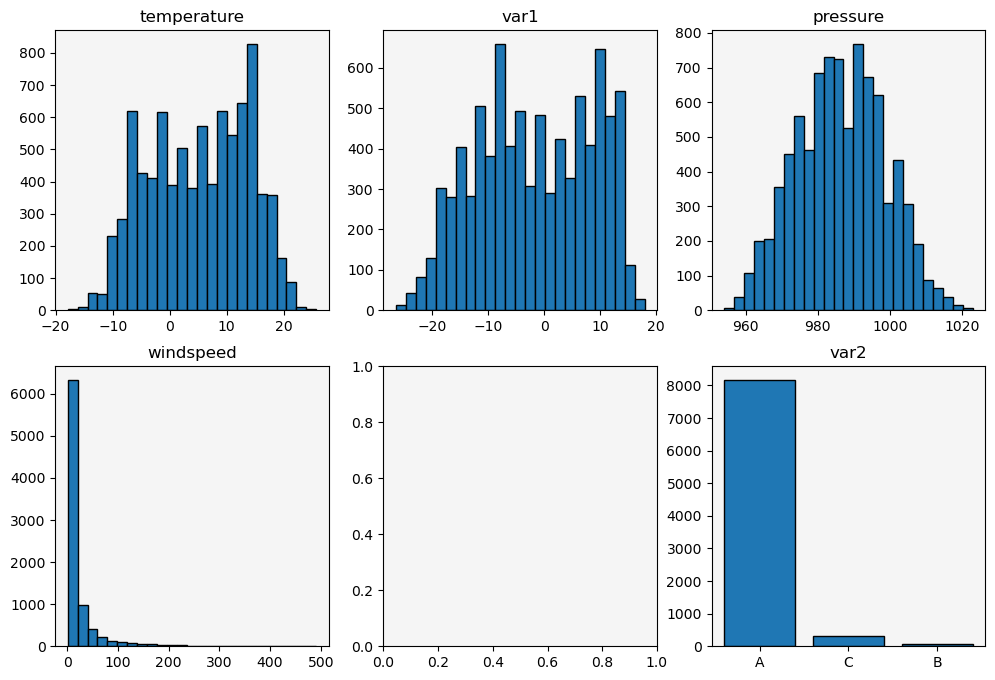

In [42]:
## inspect histograms of test column data
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
cols = ['temperature','var1','pressure','windspeed']
for i in range(0,len(cols)):
    axs[i//3,i-3*(i//3)].hist(test[cols[i]],bins=25,edgecolor='black')
    axs[i//3,i-3*(i//3)].set_title(cols[i])
categories = test['var2'].value_counts().index
counts = test['var2'].value_counts().values
axs[1,2].bar(categories, counts, edgecolor='black')
axs[1,2].set_title('var2')

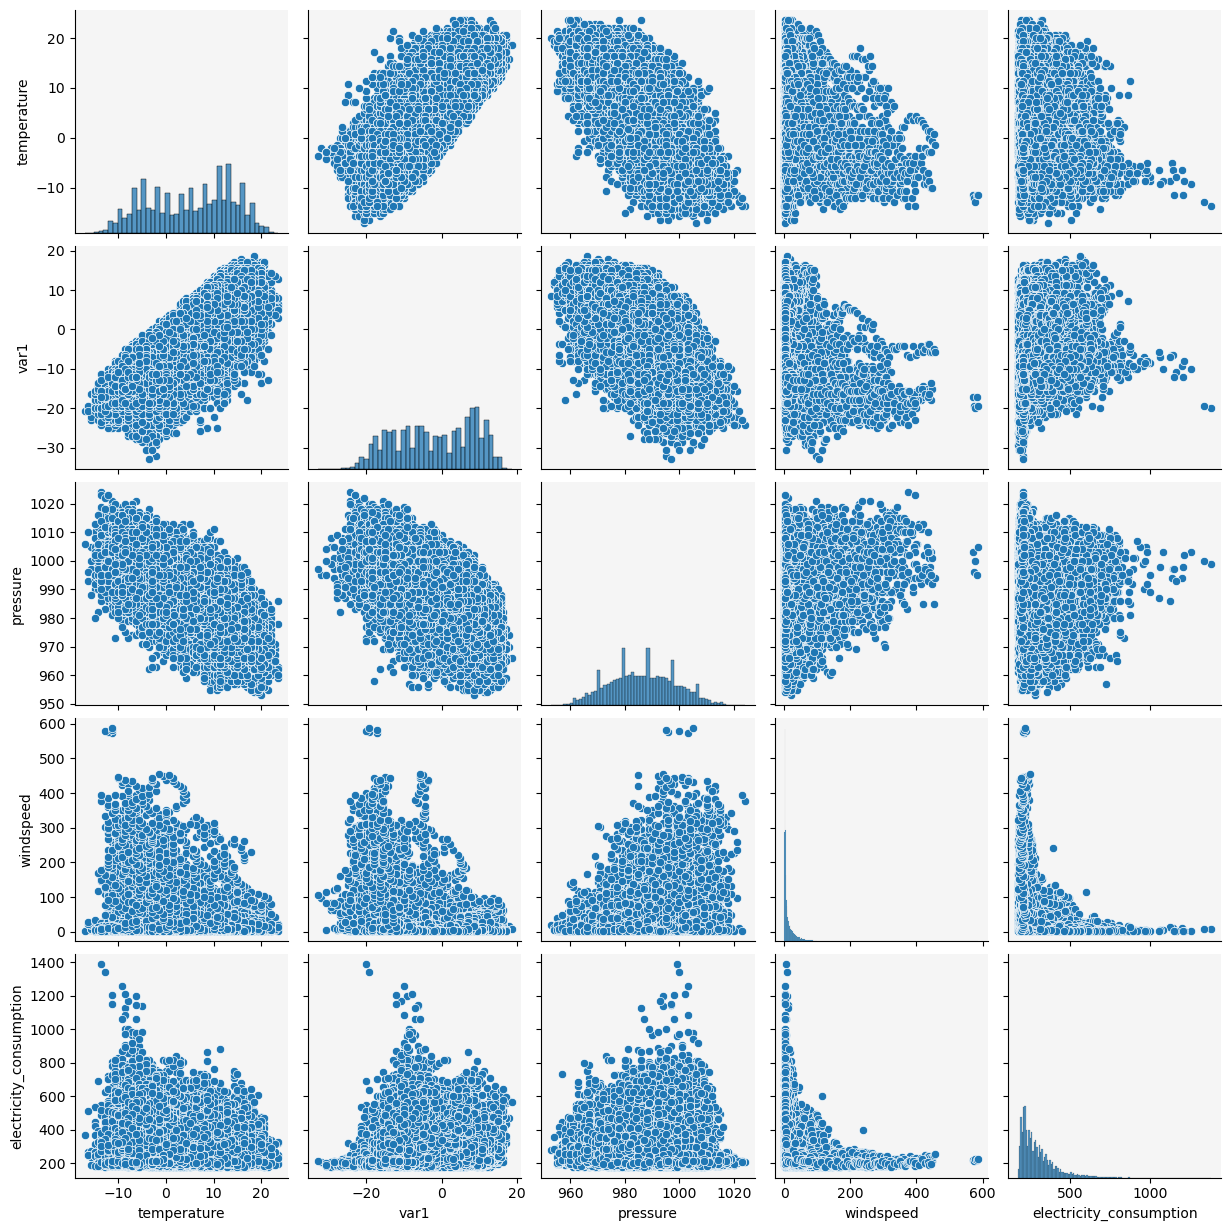

In [43]:
## inspect scatterplots
sb.pairplot(train.loc[:, train.columns != 'ID'])

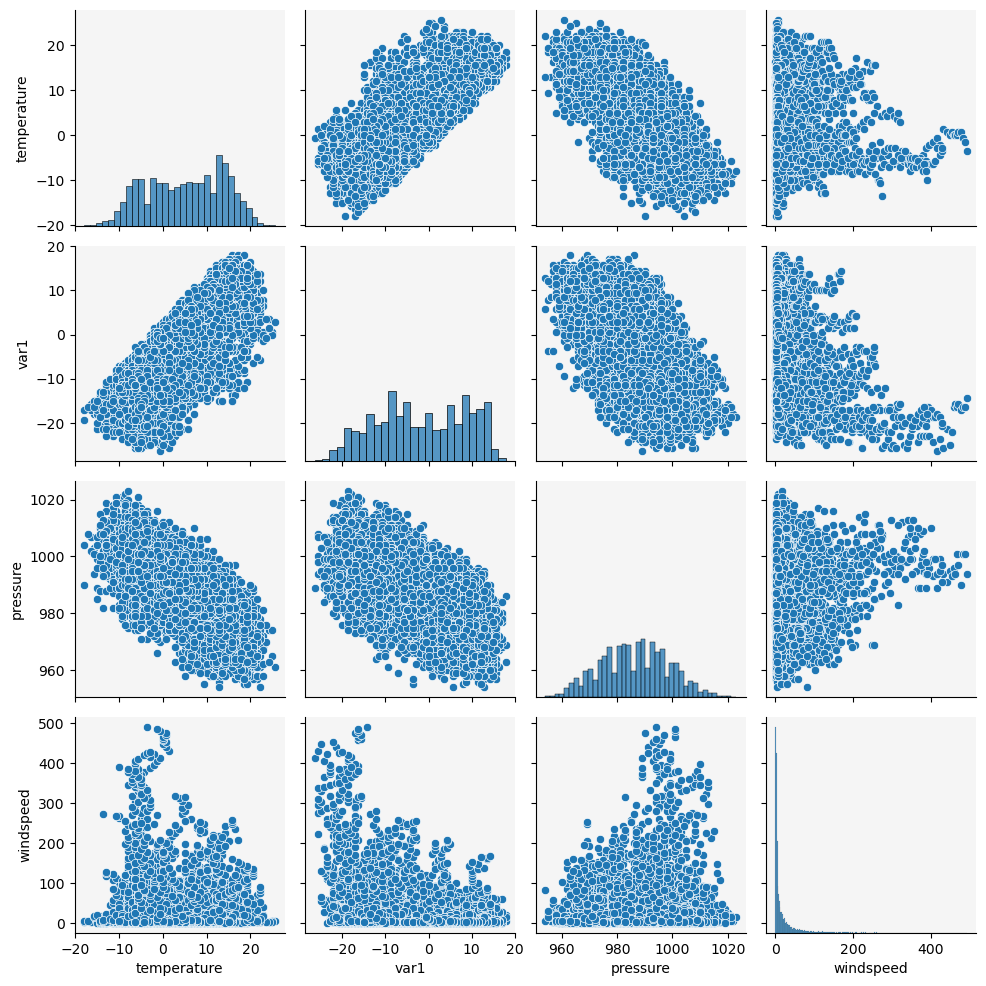

In [44]:
## inspect scatterplots
sb.pairplot(test.loc[:, test.columns != 'ID'])

Text(0.5, 1.0, 'Test')

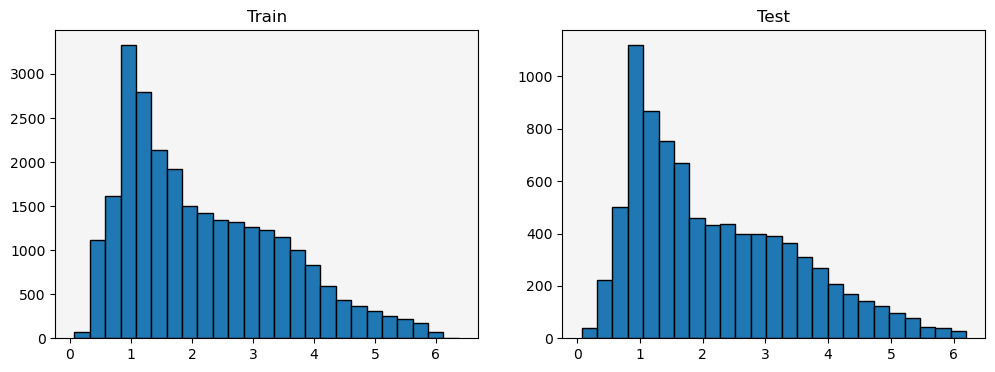

In [45]:
## logged windspeed histograms to reduce right tails
fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,4)
axs[0].hist((np.log(train['windspeed'])),bins=25,edgecolor='black')
axs[1].hist(np.log(test['windspeed']),bins=25,edgecolor='black')
axs[0].set_title('Train')
axs[1].set_title('Test')

In [46]:
## just testing things here
np.corrcoef(1/train['windspeed'], 1/np.log(train['electricity_consumption']))

array([[ 1.       , -0.2890275],
       [-0.2890275,  1.       ]])

(array([1.042e+03, 2.747e+03, 3.687e+03, 2.552e+03, 2.546e+03, 2.653e+03,
        2.202e+03, 2.135e+03, 1.773e+03, 1.447e+03, 1.050e+03, 7.170e+02,
        5.270e+02, 4.520e+02, 3.830e+02, 2.490e+02, 1.610e+02, 9.500e+01,
        4.000e+01, 1.400e+01, 8.000e+00, 4.000e+00, 6.000e+00, 4.000e+00,
        2.000e+00]),
 array([5.1590553 , 5.24206017, 5.32506505, 5.40806992, 5.4910748 ,
        5.57407968, 5.65708455, 5.74008943, 5.8230943 , 5.90609918,
        5.98910405, 6.07210893, 6.1551138 , 6.23811868, 6.32112355,
        6.40412843, 6.4871333 , 6.57013818, 6.65314305, 6.73614793,
        6.8191528 , 6.90215768, 6.98516255, 7.06816743, 7.1511723 ,
        7.23417718]),
 <BarContainer object of 25 artists>)

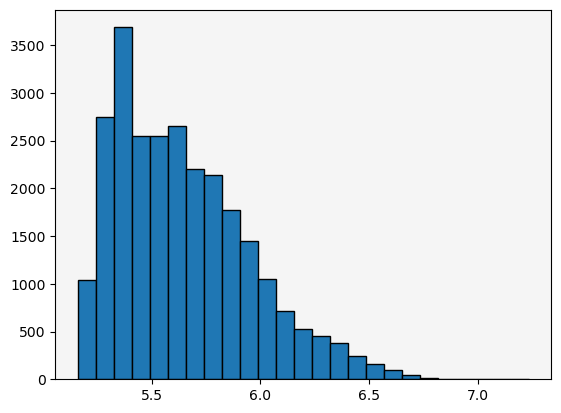

In [48]:
plt.hist(np.log(train['electricity_consumption']),bins=25,edgecolor='black')

/opt/anaconda3/envs/pyfun/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


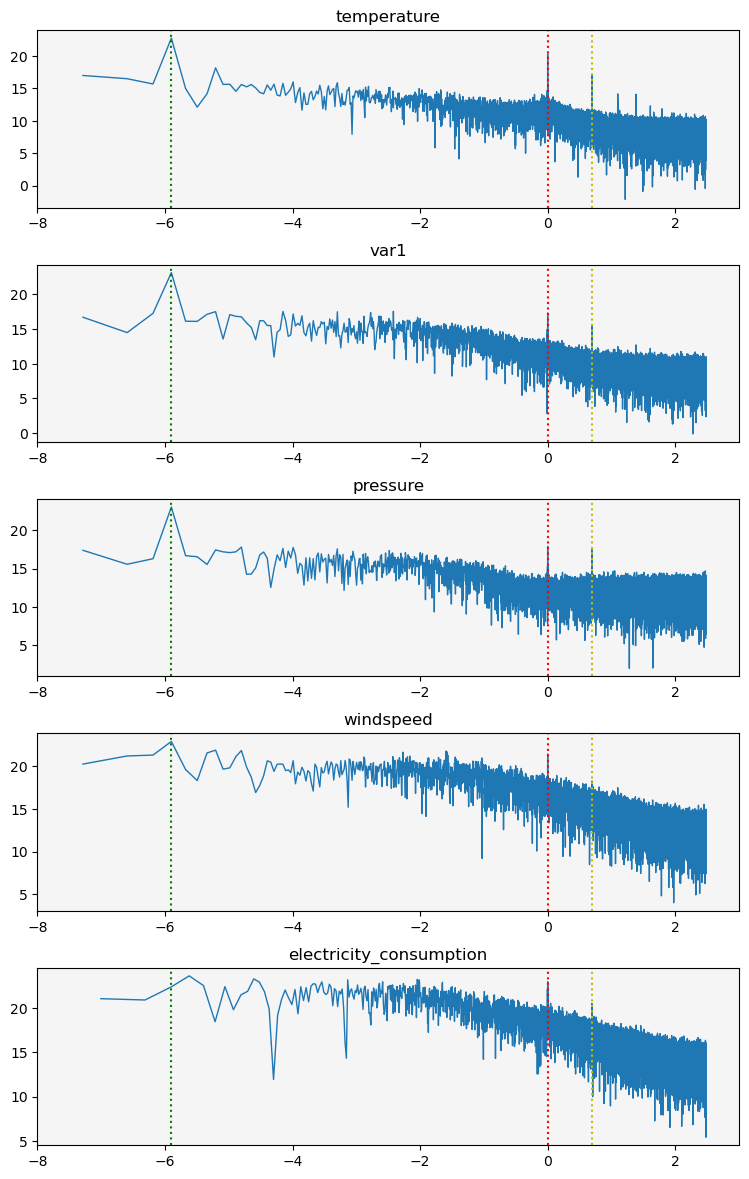

In [49]:
## sanity check power spectra for numerical columns

## Create a full, combined dataset so annual mode appears at the correct place
full = pd.concat([train,test],axis=0,sort=True).sort_values(by=['datetime'])
full.set_index('ID')

cols = ['temperature','var1','pressure','windspeed','electricity_consumption']
fig, axs = plt.subplots(len(cols),1)
fig.set_size_inches(8,12)
fig.tight_layout(pad=2.0)
for i in range(0,len(cols)):
    x = full[cols[i]][~full[cols[i]].isnull()]
    dt = 3600 ## timestep = 3600s between obs
    N = len(x)
    T = N*dt
    xf = np.fft.fft(x-x.mean())
    Sxx = 2*dt**2/T*(xf*xf.conj())
    Sxx = Sxx[:int(len(x)/2)]
    df = 1/T
    fNQ = 1/dt/2
    faxis = np.arange(0,fNQ,df)
    axs[i].plot(np.log(faxis*3600*24), np.log(Sxx.real), linewidth=1)
    axs[i].set_xlim([-8,3])
    axs[i].set_title(cols[i])
    axs[i].axvline(x=np.log(1),color='r',linestyle=':') ## check for diurnal peak
    axs[i].axvline(x=np.log(1/365),color='g',linestyle=':') ## check for annual peak
    axs[i].axvline(x=np.log(2),color='y',linestyle=':') ## check for semi-diurnal peak

Text(0.5, 1.0, 'var2')

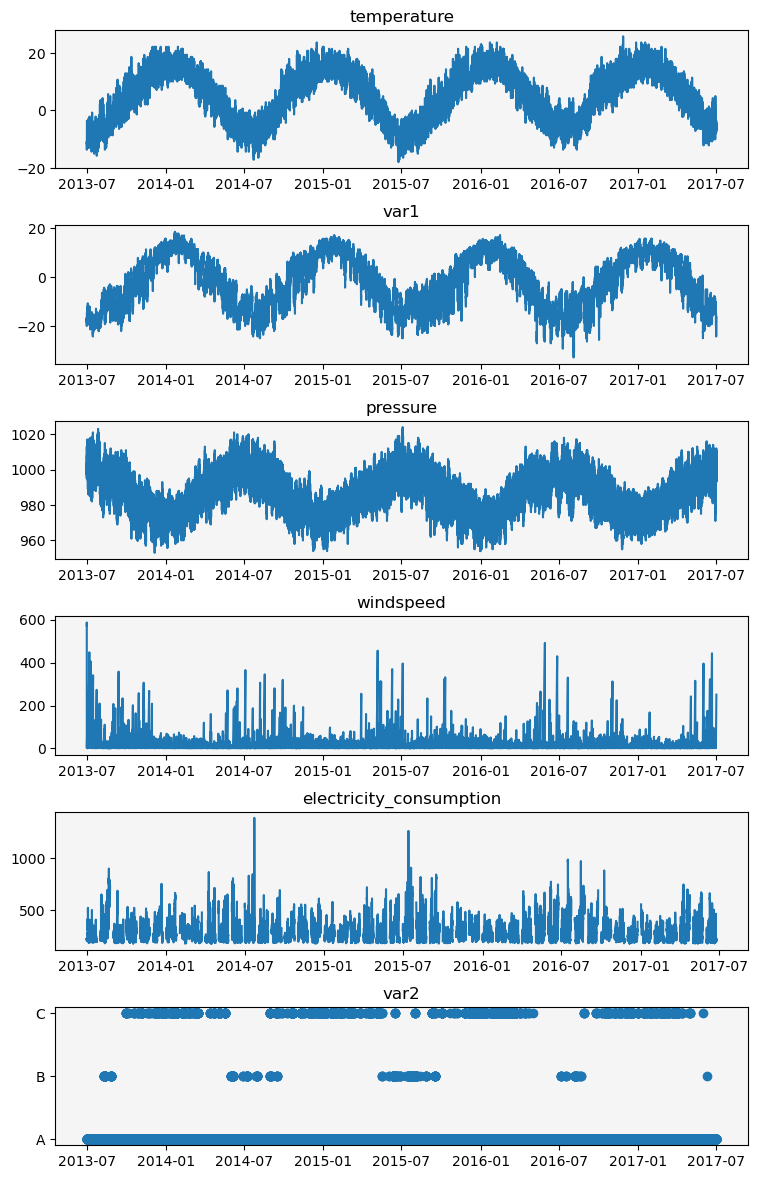

In [50]:
## sanity check time series plots
cols = ['temperature','var1','pressure','windspeed','electricity_consumption']
fig, axs = plt.subplots(len(cols)+1,1)
fig.set_size_inches(8,12)
fig.tight_layout(pad=2.0)
for i in range(0,len(cols)):
    axs[i].plot(pd.to_datetime(full['datetime']),cols[i],data=full)
    axs[i].set_title(cols[i])
axs[5].scatter(pd.to_datetime(full['datetime']),'var2',data=full)
axs[5].set_title('var2')

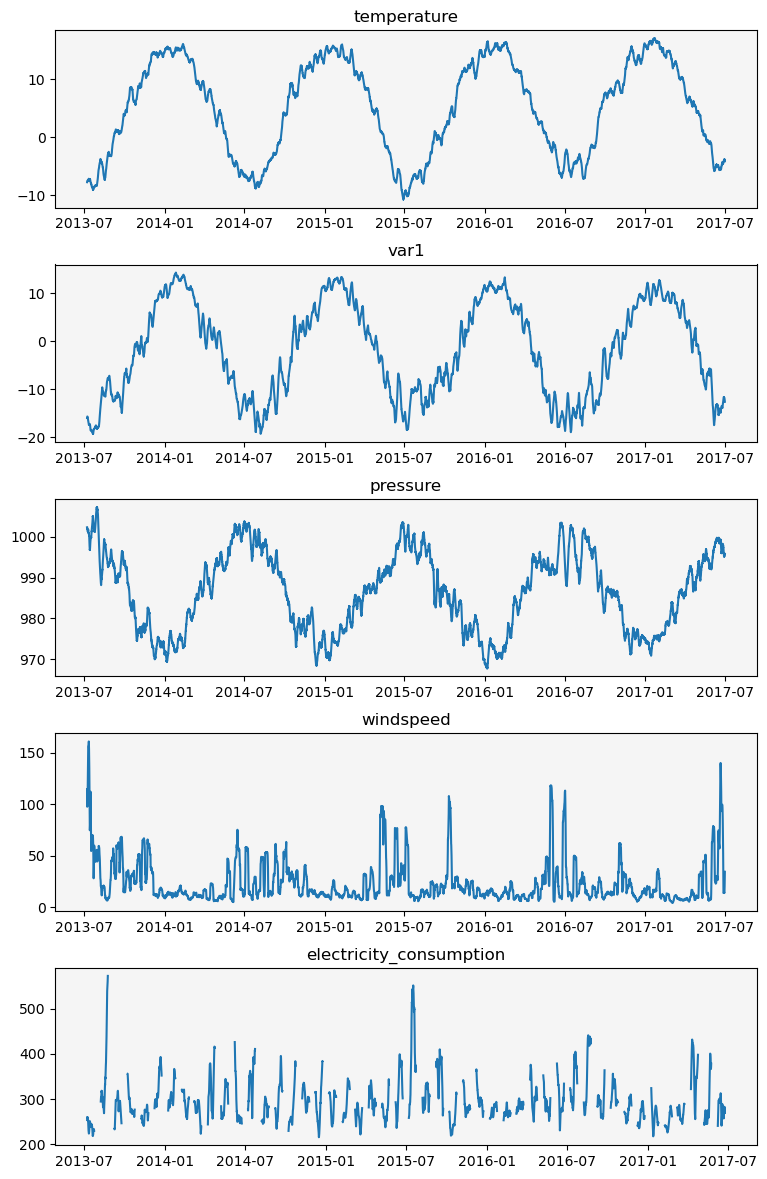

In [51]:
## sanity check time series plots, rolling averages
cols = ['temperature','var1','pressure','windspeed','electricity_consumption']
fig, axs = plt.subplots(len(cols),1)
fig.set_size_inches(8,12)
fig.tight_layout(pad=2.0)
for i in range(0,len(cols)):
    axs[i].plot(pd.to_datetime(full['datetime']),full[cols[i]].rolling(24*7).mean())
    axs[i].set_title(cols[i])

In [52]:
## Convert datetime strings to pandas datetime 
full['datetime'] = pd.to_datetime(full['datetime'])

## Create hour and month columns
full['hour'] = full['datetime'].dt.hour
full['month'] = full['datetime'].dt.month

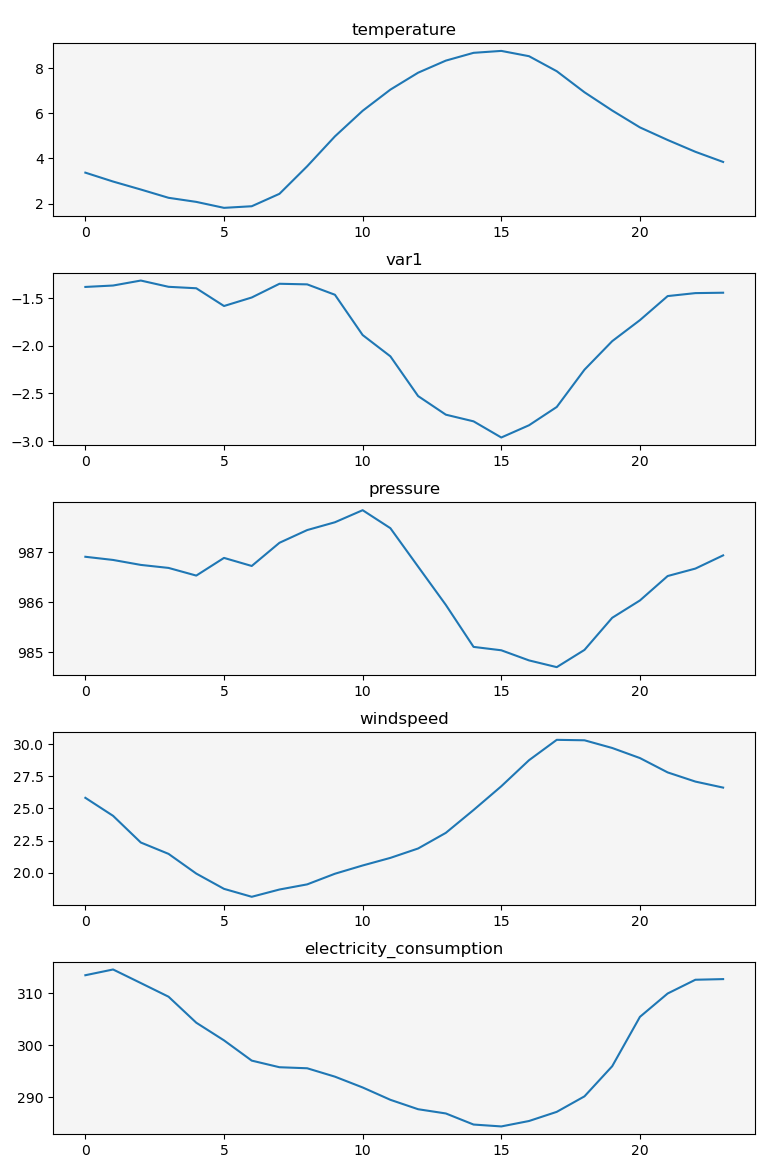

In [53]:
## Inspect diurnal trends
cols = ['temperature','var1','pressure','windspeed','electricity_consumption']
# for m in range(0,13):
m = 0
fig, axs = plt.subplots(len(cols),1)
fig.set_size_inches(8,12)
fig.tight_layout(pad=2.0,rect=[0, 0, 1, 0.98])
if (m==0):
    x = full
else:
    x = full[full['month'] == m]
for i in range(0,len(cols)):
    axs[i].plot(range(0,24),x.groupby('hour')[cols[i]].mean())
    axs[i].set_title(cols[i])
    # axs[i].set_ylim((np.min(full.groupby(['month','hour'])[cols[i]].mean()),np.max(full.groupby(['month','hour'])[cols[i]].mean())))
if (m==0):
    fig.suptitle(' ')
else:
    fig.suptitle('Month = ' + str(m))

In [54]:
## Add logged windspeed and electricity_consumption columns; check correlations
train['ws'] = np.log(train['windspeed'])
test['ws'] = np.log(test['windspeed'])
train['ec'] = np.log(train['electricity_consumption'])
train.loc[:, train.columns != 'ID'].corr(method='pearson')

temperature      var1  pressure  windspeed  \
temperature                 1.000000  0.811421 -0.723939  -0.162093   
var1                        0.811421  1.000000 -0.680821  -0.292305   
pressure                   -0.723939 -0.680821  1.000000   0.171369   
windspeed                  -0.162093 -0.292305  0.171369   1.000000   
electricity_consumption    -0.117254  0.133914  0.000907  -0.238883   
ws                         -0.036442 -0.241529  0.086190   0.762430   
ec                         -0.076493  0.193445 -0.038735  -0.278174   

                         electricity_consumption        ws        ec  
temperature                            -0.117254 -0.036442 -0.076493  
var1                                    0.133914 -0.241529  0.193445  
pressure                                0.000907  0.086190 -0.038735  
windspeed                              -0.238883  0.762430 -0.278174  
electricity_consumption                 1.000000 -0.301689  0.975914  
ws                                     -0.301689  1.000000 -0.333496  
ec                                      0.975914 -0.333496  1.000000

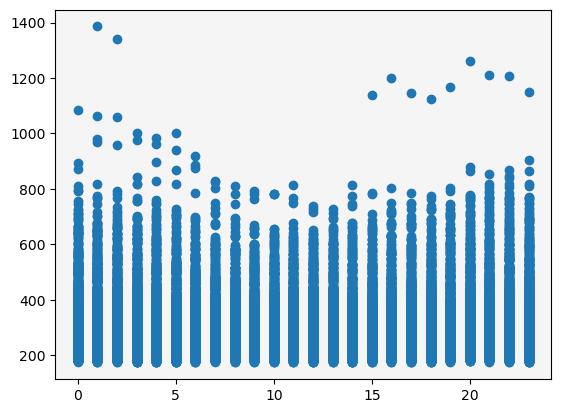

In [55]:
## Electricity consumption trends vs hour
plt.scatter('hour','electricity_consumption',data=full)

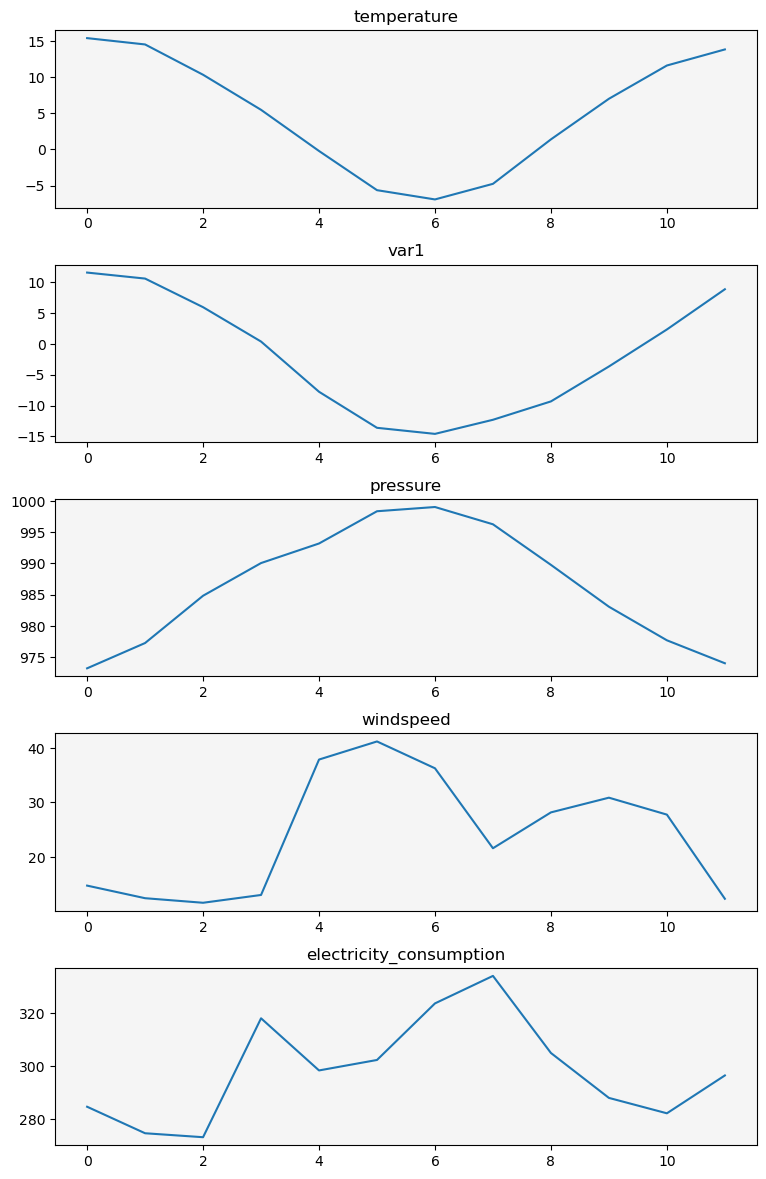

In [56]:
## Inspect annual tendencies
cols = ['temperature','var1','pressure','windspeed','electricity_consumption']
fig, axs = plt.subplots(len(cols),1)
fig.set_size_inches(8,12)
fig.tight_layout(pad=2.0)
for i in range(0,len(cols)):
    # x = full[full['month'] == 1]
    axs[i].plot(range(0,12),full.groupby('month')[cols[i]].mean())
    axs[i].set_title(cols[i])

In [57]:
## Remove large windspeeds
idx = train['windspeed'] > 500
train.loc[idx,'windspeed'] = np.nan
print(str(np.sum(idx)) + ' large windspeeds removed')
train['ws'] = np.log(train['windspeed'])

5 large windspeeds removed


In [58]:
## Remove large electricity_consumption
idx = train['electricity_consumption'] > 1000
train.loc[idx,'electricity_consumption'] = np.nan
print(str(np.sum(idx)) + ' large electricity_consumption removed')
train['ec'] = np.log(train['electricity_consumption'])
train.loc[:, train.columns != 'ID'].corr(method='pearson')

16 large electricity_consumption removed


temperature      var1  pressure  windspeed  \
temperature                 1.000000  0.811421 -0.723939  -0.159924   
var1                        0.811421  1.000000 -0.680821  -0.292582   
pressure                   -0.723939 -0.680821  1.000000   0.171124   
windspeed                  -0.159924 -0.292582  0.171124   1.000000   
electricity_consumption    -0.111686  0.140655 -0.003081  -0.243219   
ws                         -0.035293 -0.240848  0.085604   0.765744   
ec                         -0.072570  0.196910 -0.041200  -0.280572   

                         electricity_consumption        ws        ec  
temperature                            -0.111686 -0.035293 -0.072570  
var1                                    0.140655 -0.240848  0.196910  
pressure                               -0.003081  0.085604 -0.041200  
windspeed                              -0.243219  0.765744 -0.280572  
electricity_consumption                 1.000000 -0.304801  0.979186  
ws                                     -0.304801  1.000000 -0.333871  
ec                                      0.979186 -0.333871  1.000000

In [66]:
## Remove two outliers from windspeed vs electricity_consumption scatterplot
a = train[train['windspeed'].between(200,250)]['electricity_consumption'].idxmax()
train.loc[a,'electricity_consumption'] = np.nan
a = train[train['windspeed'].between(100,200)]['electricity_consumption'].idxmax()
train.loc[a,'electricity_consumption'] = np.nan
train['ws'] = np.log(train['windspeed'])
train['ec'] = np.log(train['electricity_consumption'])
train.loc[:, train.columns != 'ID'].corr(method='pearson')

temperature      var1  pressure  windspeed  \
temperature                 1.000000  0.811421 -0.723939  -0.159924   
var1                        0.811421  1.000000 -0.680821  -0.292582   
pressure                   -0.723939 -0.680821  1.000000   0.171124   
windspeed                  -0.159924 -0.292582  0.171124   1.000000   
electricity_consumption    -0.111452  0.140933 -0.003296  -0.243906   
ws                         -0.035293 -0.240848  0.085604   0.765744   
ec                         -0.072335  0.197183 -0.041414  -0.281308   
hour                        0.154194 -0.021886 -0.033808   0.057855   
month                      -0.185422 -0.313373  0.044578   0.077851   

                         electricity_consumption        ws        ec  \
temperature                            -0.111452 -0.035293 -0.072335   
var1                                    0.140933 -0.240848  0.197183   
pressure                               -0.003296  0.085604 -0.041414   
windspeed                              -0.243906  0.765744 -0.281308   
electricity_consumption                 1.000000 -0.305387  0.979182   
ws                                     -0.305387  1.000000 -0.334463   
ec                                      0.979182 -0.334463  1.000000   
hour                                   -0.021815  0.148317 -0.025171   
month                                   0.040831  0.106840  0.044021   

                                 hour         month  
temperature              1.541935e-01 -1.854224e-01  
var1                    -2.188607e-02 -3.133730e-01  
pressure                -3.380843e-02  4.457814e-02  
windspeed                5.785498e-02  7.785070e-02  
electricity_consumption -2.181475e-02  4.083094e-02  
ws                       1.483165e-01  1.068402e-01  
ec                      -2.517147e-02  4.402119e-02  
hour                     1.000000e+00  2.950785e-16  
month                    2.950785e-16  1.000000e+00

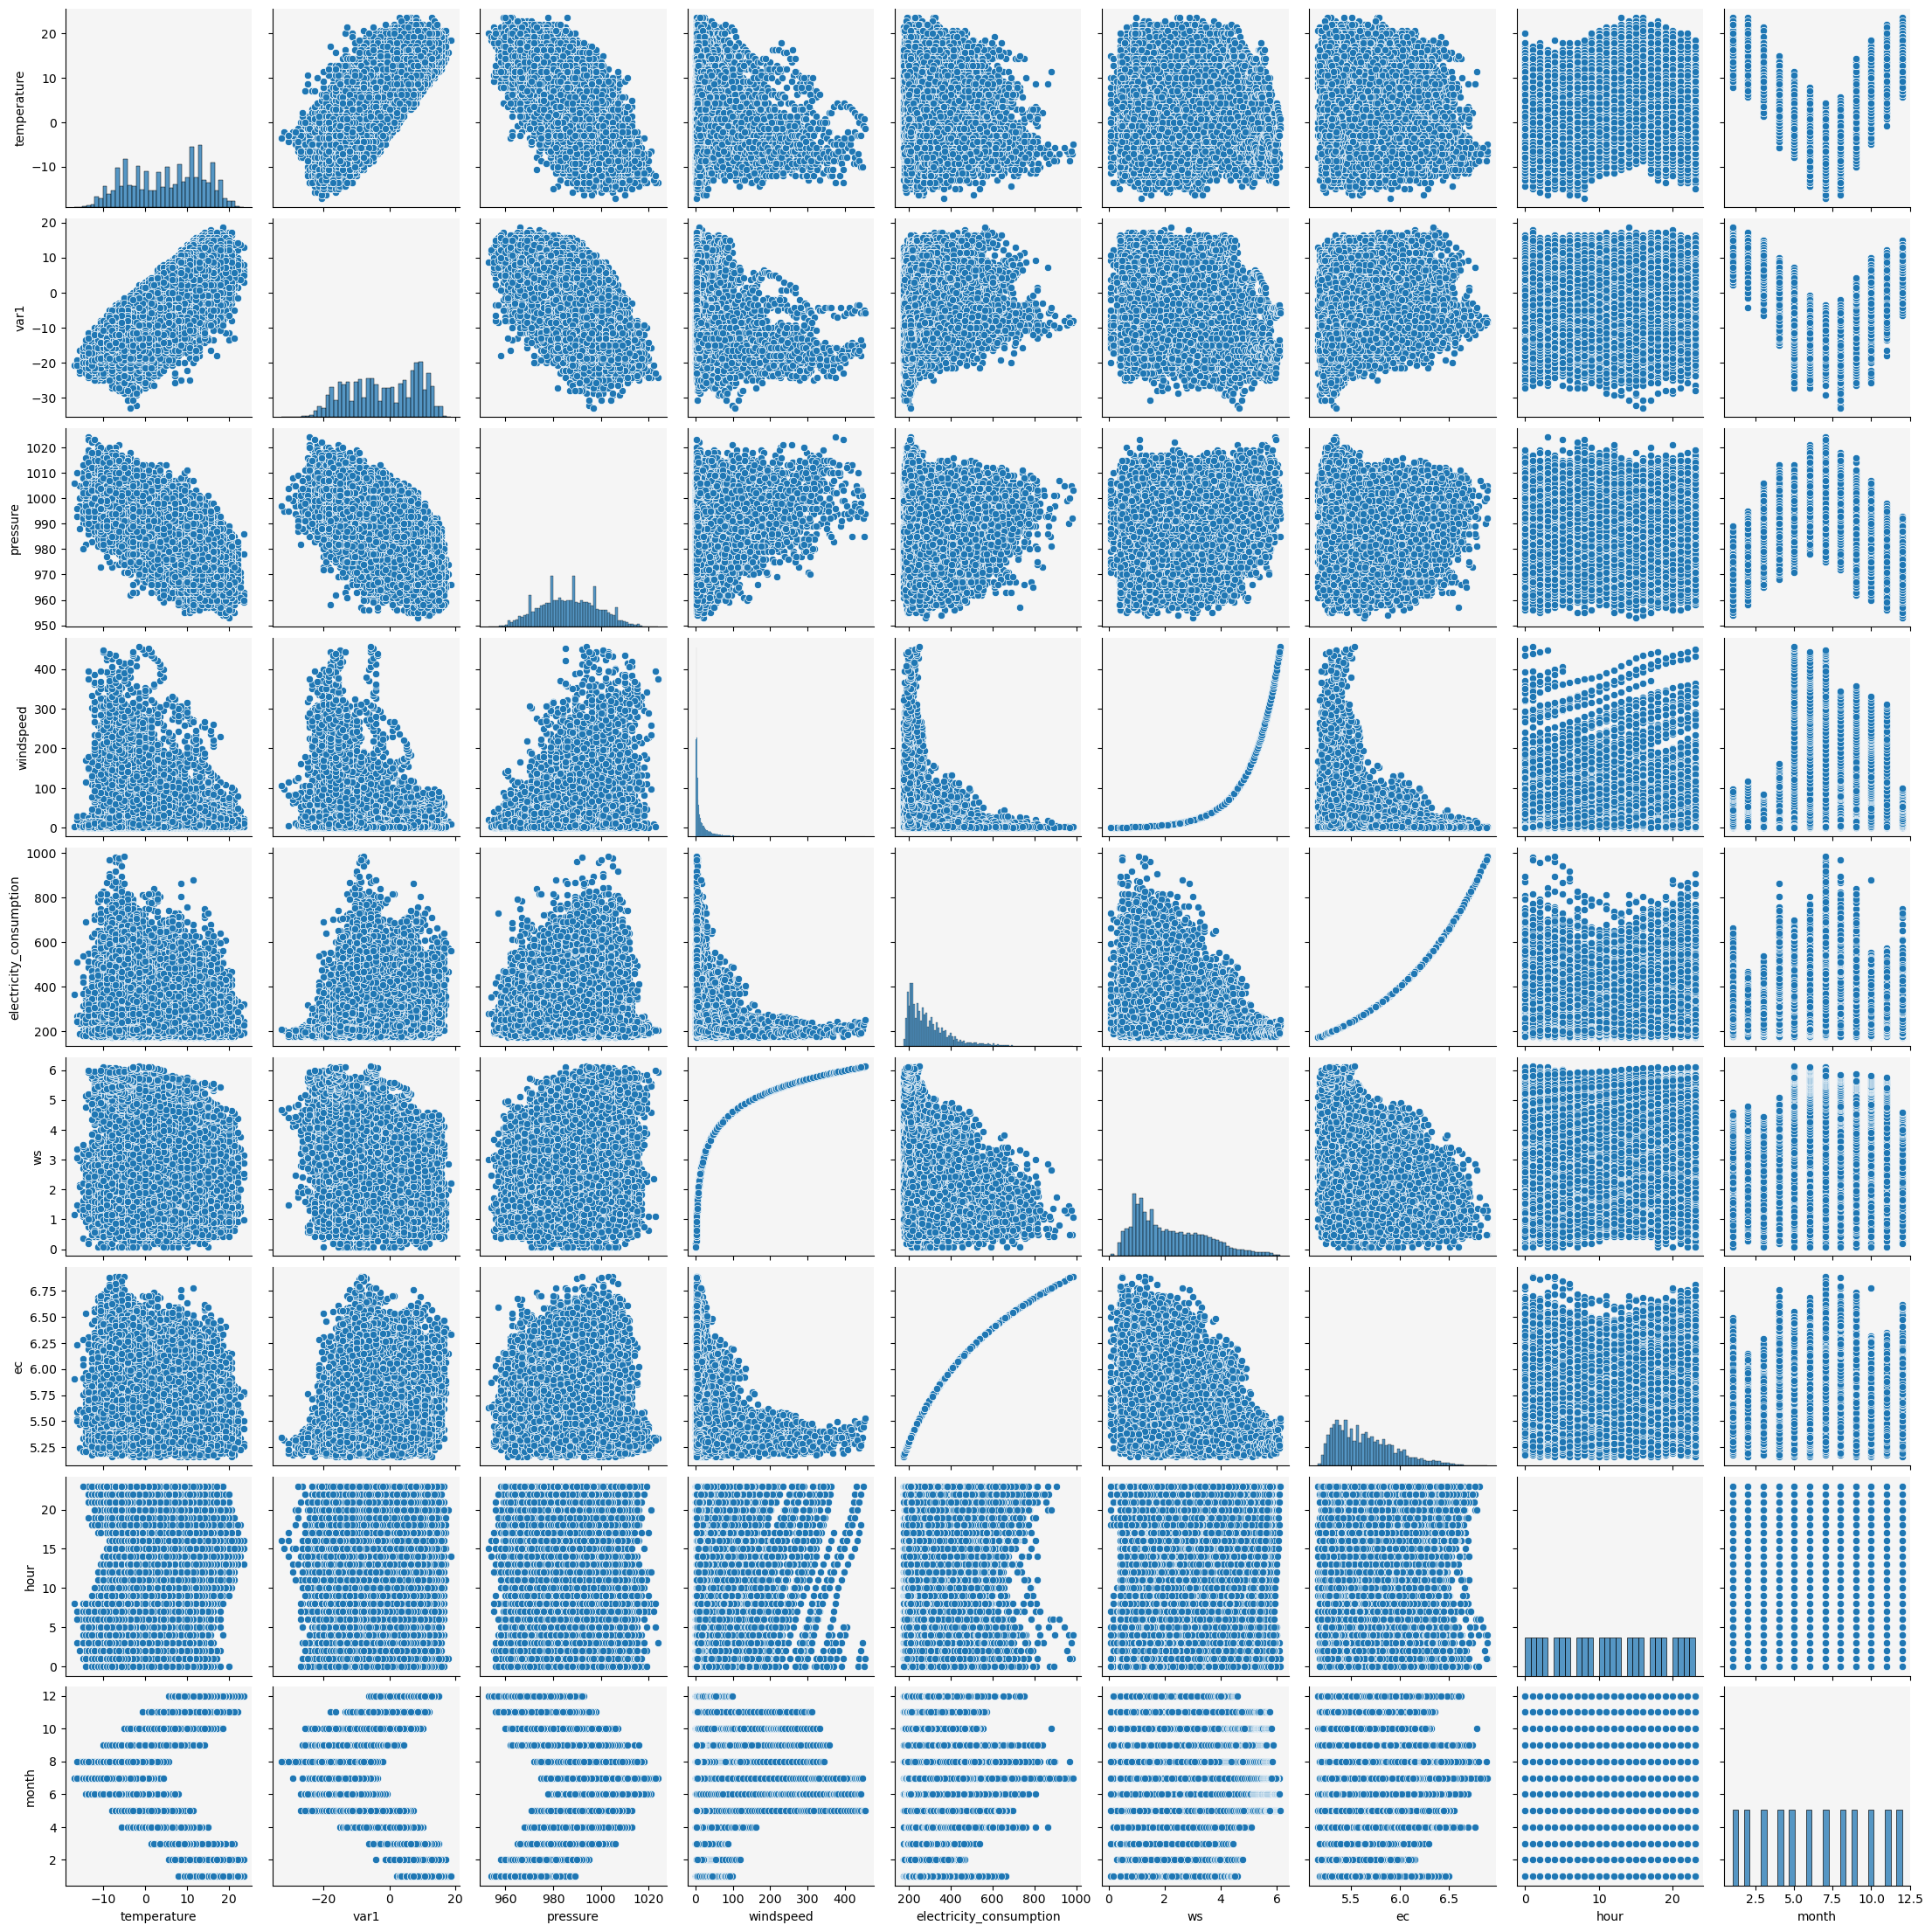

In [67]:
## Re-check scatterplots after outlier removal
sb.pairplot(train.loc[:, train.columns != 'ID'])

In [68]:
## PCA for highly correlated var1, temperature, and pressure fields
x = train.loc[:,['var1', 'temperature', 'pressure']].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=1)
tpv = pca.fit_transform(x)
train['tpv'] = tpv
train.loc[:, train.columns != 'ID'].corr(method='pearson')

temperature      var1  pressure  windspeed  \
temperature                 1.000000  0.811421 -0.723939  -0.159924   
var1                        0.811421  1.000000 -0.680821  -0.292582   
pressure                   -0.723939 -0.680821  1.000000   0.171124   
windspeed                  -0.159924 -0.292582  0.171124   1.000000   
electricity_consumption    -0.111452  0.140933 -0.003296  -0.243906   
ws                         -0.035293 -0.240848  0.085604   0.765744   
ec                         -0.072335  0.197183 -0.041414  -0.281308   
hour                        0.154194 -0.021886 -0.033808   0.057855   
month                      -0.185422 -0.313373  0.044578   0.077851   
tpv                        -0.932319 -0.915789  0.878022   0.228866   

                         electricity_consumption        ws        ec  \
temperature                            -0.111452 -0.035293 -0.072335   
var1                                    0.140933 -0.240848  0.197183   
pressure                               -0.003296  0.085604 -0.041414   
windspeed                              -0.243906  0.765744 -0.281308   
electricity_consumption                 1.000000 -0.305387  0.979182   
ws                                     -0.305387  1.000000 -0.334463   
ec                                      0.979182 -0.334463  1.000000   
hour                                   -0.021815  0.148317 -0.025171   
month                                   0.040831  0.106840  0.044021   
tpv                                    -0.011344  0.132584 -0.060342   

                                 hour         month       tpv  
temperature              1.541935e-01 -1.854224e-01 -0.932319  
var1                    -2.188607e-02 -3.133730e-01 -0.915789  
pressure                -3.380843e-02  4.457814e-02  0.878022  
windspeed                5.785498e-02  7.785070e-02  0.228866  
electricity_consumption -2.181475e-02  4.083094e-02 -0.011344  
ws                       1.483165e-01  1.068402e-01  0.132584  
ec                      -2.517147e-02  4.402119e-02 -0.060342  
hour                     1.000000e+00  2.950785e-16 -0.061884  
month                    2.950785e-16  1.000000e+00  0.201305  
tpv                     -6.188413e-02  2.013049e-01  1.000000

In [69]:
## Convert datetime strings to pandas datetime 
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

## Create hour and month columns
train['hour'] = train['datetime'].dt.hour
train['month'] = train['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['month'] = test['datetime'].dt.month

In [72]:
## Collect input features into array
X = np.array(train.loc[:,['var1','ws']])
y = np.array(train['ec'])
X = np.concatenate((np.ones((len(train['var1']),1)), X), axis=1)
X_applied = np.array(test[['var1','ws']])
X_applied = np.concatenate((np.ones((len(test['var1']),1)), X_applied), axis=1)
np.shape(X)

(26496, 3)

In [73]:
## One hot encoding for categorical variables var2, hour, and month
enc = OneHotEncoder(drop='first')
for c in ['var2','month','hour']:
    enc.fit(train[c].to_numpy().reshape(-1, 1))
    X = np.concatenate((X,enc.transform(train[c].to_numpy().reshape(-1,1)).toarray()), axis=1)
    enc.fit(test[c].to_numpy().reshape(-1, 1))
    X_applied = np.concatenate((X_applied,enc.transform(test[c].to_numpy().reshape(-1,1)).toarray()), axis=1)
np.shape(X)

(26496, 39)

In [74]:
## Remove nan rows 
idx = ~np.isnan(np.concatenate((y.reshape(-1, 1), X), axis=1)).any(axis=1)
X = X[idx,]
y = y[idx,]

idx_test_set = ~np.isnan(X_applied).any(axis=1)
X_applied = X_applied[idx_test_set,]

In [75]:
## Train-test split for training/testing model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=False)

In [76]:
## Perform backward BIC elimination feature selection
## Recursively eliminate feature with largest p-value until BIC no longer decreases
def backwardElim(model, X, y, X_test, X_applied):
    cur_bic = model.bic
    pvals = model.pvalues
    if any(np.isnan(pvals)):
        max_ind = np.argwhere(np.isnan(pvals))
    else:
        max_ind = np.argmax(pvals)
    X_new = np.delete(X,max_ind,axis=1)
    X_test_new = np.delete(X_test,max_ind,axis=1)
    X_applied_new = np.delete(X_applied,max_ind,axis=1)
    model_new = sm.OLS(y, X_new).fit()
    new_bic = model_new.bic
    if ((new_bic < cur_bic) or any(np.isnan(pvals))):
        print('removed column ' + str(max_ind))
        return backwardElim(model_new, X_new, y, X_test_new, X_applied_new)
    else:
        return model, X, X_test, X_applied

In [77]:
## Use Cook's Distance to remove high-influence points
def removeHiInf(model, X, y):
    ## Get Cook's Distance
    cd = model.get_influence().cooks_distance[0]
    hi_inf = cd > 4/len(cd)
    ## Remove high-influence points
    X = X[~hi_inf,]
    y = y[~hi_inf,]
    
    print(str(np.sum(hi_inf)) + ' highly influential data points removed')
    
    model = sm.OLS(y, X).fit()
    
    return model, X, y

In [78]:
## Fit an additive linear model to the data

m = sm.OLS(y_train,X_train).fit()

## Store rmse
rmses = pd.DataFrame({'Train': rmse(np.exp(y_train),np.exp(m.predict(X_train))),
                      'Test': rmse(np.exp(y_test),np.exp(m.predict(X_test))),
                      'R^2': m.rsquared}, index=['add_mod_1'])


print('Train RMSE: ' + str(rmses['Train'][0]))
print(' Test RMSE: ' + str(rmses['Test'][0]))

m.summary()

Train RMSE: 82.93345158881837
 Test RMSE: 84.96184885244692


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     367.1
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:25:06   Log-Likelihood:                 573.52
No. Observations:               19853   AIC:                            -1069.
Df Residuals:                   19814   BIC:                            -761.1
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3173      0.012    455.329      0.000       5.294       5.340
x1             0.0376      0.000     94.934      0.000       0.037       0.038
x2            -0.0430      0.001    -30.358      0.000      -0.046      -0.040
x3            -0.0798      0.018     -4.402      0.000      -0.115      -0.044
x4            -0.1015      0.009    -11.831      0.000      -0.118      -0.085
x5             0.0048      0.008      0.583      0.560      -0.011       0.021
x6             0.1386      0.008     16.406      0.000       0.122       0.155
x7             0.4294      0.009     46.199      0.000       0.411       0.448
x8             0.6936      0.011     64.445      0.000       0.672       0.715
x9             0.9717      0.013     76.646      0.000       0.947       0.997
x10            1.0328      0.013     78.505      0.000       1.007       1.059
x11            0.9937      0.013     77.838      0.000       0.969       1.019
x12            0.8477      0.012     72.761      0.000       0.825       0.870
x13            0.6165      0.010     60.016      0.000       0.596       0.637
x14            0.3862      0.009     42.837      0.000       0.369       0.404
x15            0.1951      0.008     23.529      0.000       0.179       0.211
x16           -0.0082      0.012     -0.704      0.481      -0.031       0.015
x17           -0.0192      0.012     -1.661      0.097      -0.042       0.003
x18           -0.0251      0.012     -2.169      0.030      -0.048      -0.002
x19           -0.0385      0.012     -3.327      0.001      -0.061      -0.016
x20           -0.0425      0.012     -3.667      0.000      -0.065      -0.020
x21           -0.0561      0.012     -4.847      0.000      -0.079      -0.033
x22           -0.0587      0.012     -5.074      0.000      -0.081      -0.036
x23           -0.0535      0.012     -4.620      0.000      -0.076      -0.031
x24           -0.0550      0.012     -4.753      0.000      -0.078      -0.032
x25           -0.0442      0.012     -3.822      0.000      -0.067      -0.022
x26           -0.0413      0.012     -3.566      0.000      -0.064      -0.019
x27           -0.0333      0.012     -2.875      0.004      -0.056      -0.011
x28           -0.0238      0.012     -2.056      0.040      -0.047      -0.001
x29           -0.0283      0.012     -2.440      0.015      -0.051      -0.006
x30           -0.0189      0.012     -1.628      0.104      -0.042       0.004
x31           -0.0174      0.012     -1.500      0.134      -0.040       0.005
x32           -0.0138      0.012     -1.187      0.235      -0.036       0.009
x33           -0.0243      0.012     -2.092      0.036      -0.047      -0.002
x34           -0.0186      0.012     -1.605      0.108      -0.041       0.004
x35           -0.0004      0.012     -0.031      0.976      -0.023       0.022
x3

In [79]:
## Perform backward feature elimination on additive model
m2, X_train2, X_test2, X_applied_add = backwardElim(m, X_train, y_train, X_test, X_applied)

rmses = rmses.append(pd.DataFrame({'Train': rmse(np.exp(y_train),np.exp(m2.predict(X_train2))),
                                   'Test': rmse(np.exp(y_test),np.exp(m2.predict(X_test2))),
                                   'R^2': m2.rsquared},
                                  index=['add_mod_2']))

print('\nTrain RMSE: ' + str(rmses['Train'][1]))
print(' Test RMSE: ' + str(rmses['Test'][1]))

m2.summary()

removed column 35
removed column 35
removed column 35
removed column 35
removed column 5
removed column 15
removed column 30
removed column 29
removed column 30
removed column 28
removed column 15
removed column 25
removed column 26
removed column 15
removed column 24
removed column 23
removed column 15
removed column 21
removed column 15
removed column 19

Train RMSE: 83.09806287209933
 Test RMSE: 85.09992655640652


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     769.0
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:25:24   Log-Likelihood:                 537.72
No. Observations:               19853   AIC:                            -1037.
Df Residuals:                   19834   BIC:                            -887.4
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2961      0.007    721.739      0.000       5.282       5.310
x1             0.0378      0.000     95.763      0.000       0.037       0.039
x2            -0.0420      0.001    -30.027      0.000      -0.045      -0.039
x3            -0.0830      0.018     -4.573      0.000      -0.119      -0.047
x4            -0.1007      0.009    -11.725      0.000      -0.117      -0.084
x5             0.1373      0.007     18.607      0.000       0.123       0.152
x6             0.4292      0.008     51.675      0.000       0.413       0.446
x7             0.6944      0.010     70.149      0.000       0.675       0.714
x8             0.9738      0.012     81.682      0.000       0.950       0.997
x9             1.0350      0.012     83.303      0.000       1.011       1.059
x10            0.9960      0.012     82.896      0.000       0.972       1.020
x11            0.8489      0.011     78.303      0.000       0.828       0.870
x12            0.6166      0.009     65.784      0.000       0.598       0.635
x13            0.3853      0.008     48.137      0.000       0.370       0.401
x14            0.1934      0.007     26.813      0.000       0.179       0.208
x15           -0.0365      0.008     -4.339      0.000      -0.053      -0.020
x16           -0.0392      0.008     -4.660      0.000      -0.056      -0.023
x17           -0.0340      0.008     -4.044      0.000      -0.050      -0.017
x18           -0.0356      0.008     -4.235      0.000      -0.052      -0.019
==============================================================================
Omnibus:                      844.811   Durbin-Watson:                   0.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              976.014
Skew:                           0.501   Prob(JB):                    1.15e-212
Kurtosis:                       3.421   Cond. No.                         170.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
## Re-fit model without high-influence points
m3, X_train3, y_train3 = removeHiInf(m2, X_train2, y_train)

rmses = rmses.append(pd.DataFrame({'Train': rmse(np.exp(y_train3),np.exp(m3.predict(X_train3))),
                           'Test': rmse(np.exp(y_test),np.exp(m3.predict(X_test2))),
                           'R^2': m3.rsquared},
                          index=['add_mod_3']))

print('\nTrain RMSE: ' + str(rmses['Train'][2]))
print(' Test RMSE: ' + str(rmses['Test'][2]))

m3.summary()

1092 highly influential data points removed

Train RMSE: 66.36186144026911
 Test RMSE: 86.60840431471401


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     921.8
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:25:43   Log-Likelihood:                 3220.5
No. Observations:               18761   AIC:                            -6403.
Df Residuals:                   18742   BIC:                            -6254.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2751      0.007    807.644      0.000       5.262       5.288
x1             0.0382      0.000    107.213      0.000       0.037       0.039
x2            -0.0376      0.001    -30.323      0.000      -0.040      -0.035
x3            -0.0934      0.024     -3.960      0.000      -0.140      -0.047
x4            -0.1034      0.008    -13.046      0.000      -0.119      -0.088
x5             0.1460      0.006     22.614      0.000       0.133       0.159
x6             0.4279      0.007     57.126      0.000       0.413       0.443
x7             0.7058      0.009     79.116      0.000       0.688       0.723
x8             0.9659      0.011     89.718      0.000       0.945       0.987
x9             1.0056      0.011     88.807      0.000       0.983       1.028
x10            0.9885      0.011     90.815      0.000       0.967       1.010
x11            0.8515      0.010     87.286      0.000       0.832       0.871
x12            0.6175      0.008     73.680      0.000       0.601       0.634
x13            0.3852      0.007     54.718      0.000       0.371       0.399
x14            0.1979      0.006     31.125      0.000       0.185       0.210
x15           -0.0454      0.008     -5.715      0.000      -0.061      -0.030
x16           -0.0419      0.008     -5.371      0.000      -0.057      -0.027
x17           -0.0379      0.008     -4.848      0.000      -0.053      -0.023
x18           -0.0391      0.008     -5.046      0.000      -0.054      -0.024
==============================================================================
Omnibus:                      254.241   Durbin-Watson:                   0.346
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              261.144
Skew:                           0.281   Prob(JB):                     1.96e-57
Kurtosis:                       2.863   Cond. No.                         180.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
## Try model with second-degree interaction and polynomial features

## Build polynomial/interaction features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train_poly = np.concatenate((X_train,poly.fit_transform(X_train)), axis=1)
X_test_poly = np.concatenate((X_test,poly.fit_transform(X_test)), axis=1)
X_applied_poly = np.concatenate((X_applied,poly.fit_transform(X_applied)), axis=1)

## Fit polynomial model
m_poly = sm.OLS(y_train,X_train_poly).fit()

rmses = rmses.append(pd.DataFrame({'Train': rmse(np.exp(y_train),np.exp(m_poly.predict(X_train_poly))),
                           'Test': rmse(np.exp(y_test),np.exp(m_poly.predict(X_test_poly))),
                           'R^2': m_poly.rsquared},
                          index=['int_mod_1']))

print('\nTrain RMSE: ' + str(rmses['Train'][3]))
print(' Test RMSE: ' + str(rmses['Test'][3]))

m_poly.summary()


Train RMSE: 77.76874749694473
 Test RMSE: 80.58434844481434


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     42.72
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:30:01   Log-Likelihood:                 1844.6
No. Observations:               19853   AIC:                            -2835.
Df Residuals:                   19426   BIC:                             536.5
Df Model:                         426                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2630      0.013     99.150      0.000       1.238       1.288
x1             0.0126      0.001     10.703      0.000       0.010       0.015
x2             0.0139      0.004      3.744      0.000       0.007       0.021
x3            -0.0972      0.022     -4.356      0.000      -0.141      -0.053
x4             0.0131      0.016      0.815      0.415      -0.018       0.045
x5             0.0641      0.013      4.765      0.000       0.038       0.090
x6             0.0839      0.013      6.518      0.000       0.059       0.109
x7             0.1668      0.014     12.258      0.000       0.140       0.194
x8             0.2735      0.015     18.039      0.000       0.244       0.303
x9             0.4162      0.017     23.791      0.000       0.382       0.450
x10            0.4626      0.018     25.248      0.000       0.427       0.499
x11            0.4425      0.017     25.335      0.000       0.408       0.477
x12            0.3417      0.016     20.905      0.000       0.310       0.374
x13            0.1936      0.015     12.968      0.000       0.164       0.223
x14            0.1346      0.013     10.022      0.000       0.108       0.161
x15            0.0443      0.013      3.394      0.001       0.019       0.070
x16            0.0028      0.014      0.199      0.843      -0.025       0.030
x17            0.0069      0.014      0.490      0.624      -0.021       0.034
x18            0.0125      0.014      0.894      0.372      -0.015       0.040
x19            0.0083      0.014      0.592      0.554      -0.019       0.036
x20            0.0153      0.014      1.094      0.274      -0.012       0.043
x21           -0.0040      0.014     -0.282      0.778      -0.032       0.024
x22           -0.0021      0.014     -0.147      0.883      -0.030       0.026
x23            0.0004      0.014      0.030      0.976      -0.027       0.028
x24            0.0009      0.014      0.066      0.947      -0.027       0.029
x25            0.0048      0.014      0.346      0.730      -0.023       0.032
x26           -0.0044      0.014     -0.316      0.752      -0.031       0.023
x27           -0.0050      0.014     -0.365      0.715      -0.032       0.022
x28            0.0011      0.014      0.083      0.934      -0.025       0.028
x29           -0.0074      0.014     -0.539      0.590      -0.034       0.019
x30           -0.0101      0.014     -0.743      0.457      -0.037       0.017
x31           -0.0084      0.014     -0.606      0.545      -0.035       0.019
x32           -0.0198      0.014     -1.417      0.157      -0.047       0.008
x33           -0.0165      0.014     -1.168      0.243      -0.044       0.011
x34           -0.0227      0.014     -1.576      0.115      -0.051       0.006
x35           -0.0141      0.014     -0.987      0.324      -0.042       0.014
x3

In [82]:
## Perform backward elimination
m_poly2, X_train_poly2, X_test_poly2, X_applied_poly2 = backwardElim(m_poly, X_train_poly, y_train, X_test_poly, X_applied_poly)

rmses = rmses.append(pd.DataFrame({'Train': rmse(np.exp(y_train),np.exp(m_poly2.predict(X_train_poly2))),
                           'Test': rmse(np.exp(y_test),np.exp(m_poly2.predict(X_test_poly2))),
                           'R^2': m_poly2.rsquared},
                          index=['int_mod_2']))

print('\nTrain RMSE: ' + str(rmses['Train'][4]))
print(' Test RMSE: ' + str(rmses['Test'][4]))

m_poly2.summary()

removed column [[482]
 [483]
 [484]
 [509]
 [510]
 [535]
 [584]
 [585]
 [586]
 [587]
 [588]
 [589]
 [590]
 [591]
 [592]
 [593]
 [594]
 [595]
 [596]
 [597]
 [598]
 [599]
 [600]
 [601]
 [602]
 [603]
 [604]
 [605]
 [607]
 [608]
 [609]
 [610]
 [611]
 [612]
 [613]
 [614]
 [615]
 [616]
 [617]
 [618]
 [619]
 [620]
 [621]
 [622]
 [623]
 [624]
 [625]
 [626]
 [627]
 [629]
 [630]
 [631]
 [632]
 [633]
 [634]
 [635]
 [636]
 [637]
 [638]
 [639]
 [640]
 [641]
 [642]
 [643]
 [644]
 [645]
 [646]
 [647]
 [648]
 [650]
 [651]
 [652]
 [653]
 [654]
 [655]
 [656]
 [657]
 [658]
 [659]
 [660]
 [661]
 [662]
 [663]
 [664]
 [665]
 [666]
 [667]
 [668]
 [670]
 [671]
 [672]
 [673]
 [674]
 [675]
 [676]
 [677]
 [678]
 [679]
 [680]
 [681]
 [682]
 [683]
 [684]
 [685]
 [686]
 [687]
 [689]
 [690]
 [691]
 [692]
 [693]
 [694]
 [695]
 [696]
 [697]
 [698]
 [699]
 [700]
 [701]
 [702]
 [703]
 [704]
 [705]
 [707]
 [708]
 [709]
 [710]
 [711]
 [712]
 [713]
 [714]
 [715]
 [716]
 [717]
 [718]
 [719]
 [720]
 [721]
 [722]
 [724]
 [725

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     42.92
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:30:24   Log-Likelihood:                 1844.6
No. Observations:               19853   AIC:                            -2839.
Df Residuals:                   19428   BIC:                             516.7
Df Model:                         424                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2630      0.013     99.395      0.000       1.238       1.288
x1             0.0126      0.001     10.735      0.000       0.010       0.015
x2             0.0139      0.004      3.745      0.000       0.007       0.021
x3            -0.0971      0.019     -5.101      0.000      -0.134      -0.060
x4             0.0131      0.015      0.871      0.384      -0.016       0.043
x5             0.0641      0.013      4.766      0.000       0.038       0.090
x6             0.0839      0.013      6.520      0.000       0.059       0.109
x7             0.1668      0.014     12.272      0.000       0.140       0.193
x8             0.2734      0.015     18.091      0.000       0.244       0.303
x9             0.4162      0.017     23.925      0.000       0.382       0.450
x10            0.4626      0.018     25.347      0.000       0.427       0.498
x11            0.4425      0.017     25.457      0.000       0.408       0.477
x12            0.3417      0.016     20.995      0.000       0.310       0.374
x13            0.1936      0.015     12.988      0.000       0.164       0.223
x14            0.1346      0.013     10.034      0.000       0.108       0.161
x15            0.0443      0.013      3.396      0.001       0.019       0.070
x16            0.0028      0.014      0.199      0.843      -0.025       0.030
x17            0.0069      0.014      0.493      0.622      -0.020       0.034
x18            0.0125      0.014      0.895      0.371      -0.015       0.040
x19            0.0083      0.014      0.593      0.553      -0.019       0.036
x20            0.0153      0.014      1.096      0.273      -0.012       0.043
x21           -0.0040      0.014     -0.283      0.777      -0.032       0.024
x22           -0.0021      0.014     -0.148      0.883      -0.030       0.026
x23            0.0004      0.014      0.030      0.976      -0.027       0.028
x24            0.0009      0.014      0.066      0.947      -0.027       0.029
x25            0.0048      0.014      0.346      0.729      -0.023       0.032
x26           -0.0044      0.014     -0.317      0.752      -0.031       0.023
x27           -0.0050      0.014     -0.367      0.714      -0.032       0.022
x28            0.0011      0.014      0.083      0.934      -0.025       0.028
x29           -0.0074      0.014     -0.540      0.589      -0.034       0.019
x30           -0.0101      0.014     -0.745      0.456      -0.037       0.017
x31           -0.0084      0.014     -0.607      0.544      -0.035       0.019
x32           -0.0198      0.014     -1.420      0.156      -0.047       0.008
x33           -0.0165      0.014     -1.171      0.242      -0.044       0.011
x34           -0.0227      0.014     -1.580      0.114      -0.051       0.005
x35           -0.0141      0.014     -0.989      0.322      -0.042       0.014
x3

In [83]:
## Re-fit model without high-influence points

m_poly3, X_train_poly3, y_train_poly3 = removeHiInf(m_poly2, X_train_poly2, y_train)

rmses = rmses.append(pd.DataFrame({'Train': rmse(np.exp(y_train_poly3),np.exp(m_poly3.predict(X_train_poly3))),
                           'Test': rmse(np.exp(y_test),np.exp(m_poly3.predict(sm.add_constant(X_test_poly2)))),
                           'R^2': m_poly3.rsquared},
                          index=['int_mod_3']))

print('\nTrain RMSE: ' + str(rmses['Train'][5]))
print(' Test RMSE: ' + str(rmses['Test'][5]))

m_poly3.summary()

534 highly influential data points removed

Train RMSE: 68.09749488693126
 Test RMSE: 81.04116161536818


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     50.34
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:30:47   Log-Likelihood:                 3471.8
No. Observations:               19319   AIC:                            -6098.
Df Residuals:                   18896   BIC:                            -2769.
Df Model:                         422                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2637      0.012    107.140      0.000       1.241       1.287
x1             0.0121      0.001     11.034      0.000       0.010       0.014
x2             0.0143      0.003      4.151      0.000       0.008       0.021
x3            -0.0978      0.024     -4.152      0.000      -0.144      -0.052
x4             0.0115      0.015      0.770      0.441      -0.018       0.041
x5             0.0557      0.012      4.482      0.000       0.031       0.080
x6             0.0803      0.012      6.746      0.000       0.057       0.104
x7             0.1594      0.013     12.556      0.000       0.135       0.184
x8             0.2790      0.014     19.659      0.000       0.251       0.307
x9             0.4267      0.016     26.313      0.000       0.395       0.459
x10            0.4870      0.017     28.091      0.000       0.453       0.521
x11            0.4427      0.016     27.137      0.000       0.411       0.475
x12            0.3530      0.015     23.321      0.000       0.323       0.383
x13            0.1981      0.014     14.210      0.000       0.171       0.225
x14            0.1325      0.012     10.679      0.000       0.108       0.157
x15            0.0392      0.012      3.258      0.001       0.016       0.063
x16           -0.0027      0.013     -0.209      0.834      -0.028       0.023
x17            0.0082      0.013      0.631      0.528      -0.017       0.034
x18            0.0145      0.013      1.107      0.269      -0.011       0.040
x19            0.0094      0.013      0.719      0.472      -0.016       0.035
x20            0.0147      0.013      1.131      0.258      -0.011       0.040
x21           -0.0031      0.013     -0.238      0.812      -0.029       0.023
x22            0.0058      0.013      0.432      0.666      -0.020       0.032
x23            0.0103      0.013      0.782      0.434      -0.016       0.036
x24           -0.0018      0.013     -0.138      0.891      -0.028       0.024
x25            0.0062      0.013      0.480      0.631      -0.019       0.032
x26            0.0023      0.013      0.178      0.859      -0.023       0.027
x27           -0.0013      0.013     -0.105      0.916      -0.026       0.024
x28            0.0066      0.013      0.525      0.600      -0.018       0.031
x29           -0.0068      0.013     -0.534      0.594      -0.032       0.018
x30           -0.0054      0.013     -0.425      0.671      -0.030       0.019
x31           -0.0047      0.013     -0.367      0.714      -0.030       0.020
x32           -0.0159      0.013     -1.229      0.219      -0.041       0.009
x33           -0.0098      0.013     -0.751      0.453      -0.035       0.016
x34           -0.0165      0.013     -1.235      0.217      -0.043       0.010
x35           -0.0027      0.013     -0.206      0.837      -0.029       0.023
x3

Text(0.5, 1.0, 'CV, Interaction Model')

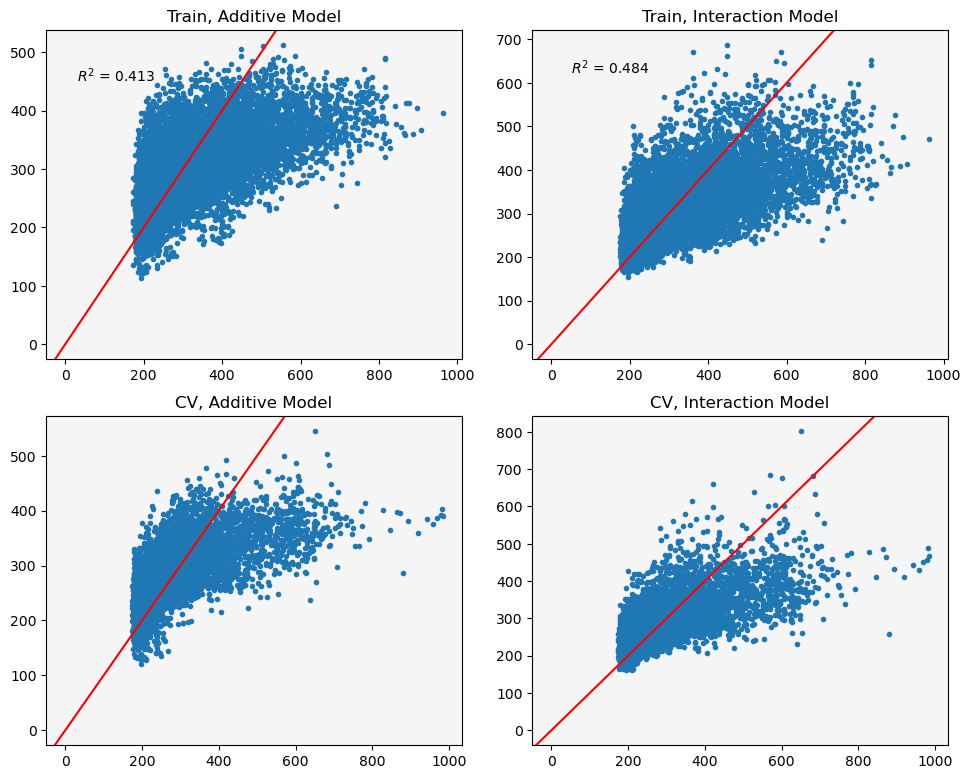

In [84]:
## Actual vs fitted for models m and m_poly2

y1_train_pred = np.exp(m.predict(X_train))
y1_test_pred = np.exp(m.predict(X_test))
y2poly_train_pred = np.exp(m_poly2.predict(X_train_poly2))
y2poly_test_pred = np.exp(m_poly2.predict(X_test_poly2))

fig, axs = plt.subplots(2,2)
fig.set_size_inches(10,8)
fig.tight_layout(pad=2.0)

axs[0,0].scatter(np.exp(y_train),y1_train_pred, marker='.')
axs[0,0].axline([0, 0], [1, 1], color='r')
axs[0,0].set_title('Train, Additive Model')
axs[0,0].text(30, 450, '$R^2$ = ' + "{:.3f}".format(m.rsquared))

axs[1,0].scatter(np.exp(y_test),y1_test_pred, marker='.')
axs[1,0].axline([0, 0], [1, 1], color='r')
axs[1,0].set_title('CV, Additive Model')

axs[0,1].scatter(np.exp(y_train),y2poly_train_pred, marker='.')
axs[0,1].axline([0, 0], [1, 1], color='r')
axs[0,1].set_title('Train, Interaction Model')
axs[0,1].text(50, 620, '$R^2$ = ' + "{:.3f}".format(m_poly2.rsquared))

axs[1,1].scatter(np.exp(y_test),y2poly_test_pred, marker='.')
axs[1,1].axline([0, 0], [1, 1], color='r')
axs[1,1].set_title('CV, Interaction Model')


Text(0.5, 1.0, 'CV, Interaction Model')

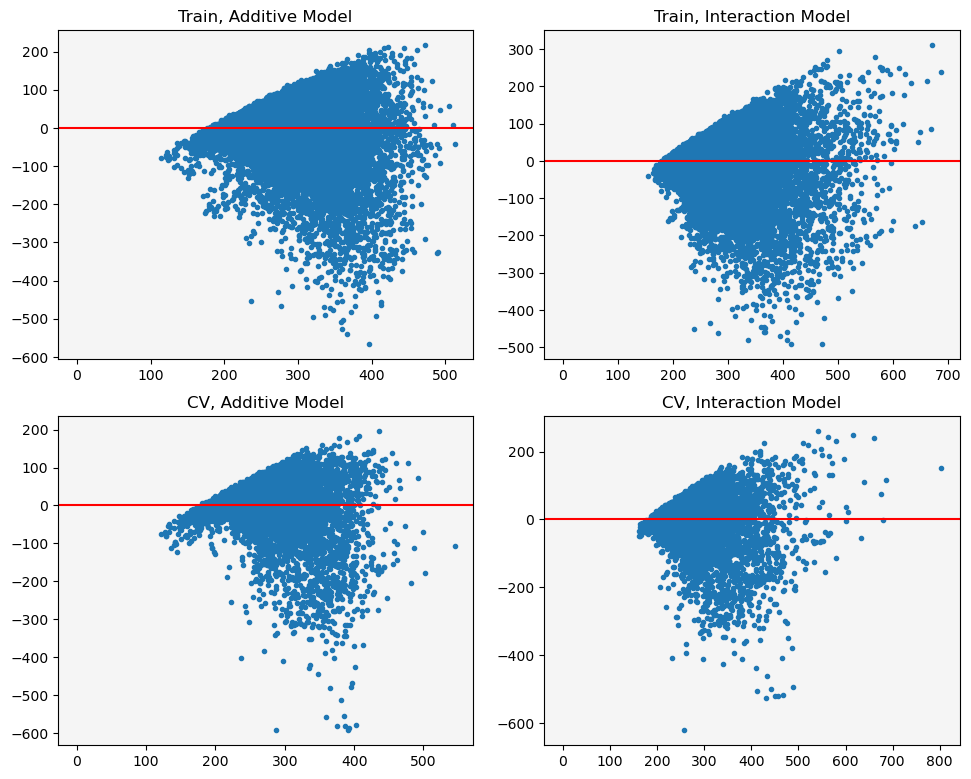

In [85]:
## Fitted vs residuals for models m and m_poly2

fig, axs = plt.subplots(2,2)
fig.set_size_inches(10,8)
fig.tight_layout(pad=2.0)

axs[0,0].scatter(y1_train_pred, y1_train_pred - np.exp(y_train), marker='.')
axs[0,0].axline([0, 0], [1, 0], color='r')
axs[0,0].set_title('Train, Additive Model')

axs[1,0].scatter(y1_test_pred, y1_test_pred - np.exp(y_test), marker='.')
axs[1,0].axline([0, 0], [1, 0], color='r')
axs[1,0].set_title('CV, Additive Model')

axs[0,1].scatter(y2poly_train_pred, y2poly_train_pred - np.exp(y_train), marker='.')
axs[0,1].axline([0, 0], [1, 0], color='r')
axs[0,1].set_title('Train, Interaction Model')

axs[1,1].scatter(y2poly_test_pred, y2poly_test_pred - np.exp(y_test), marker='.')
axs[1,1].axline([0, 0], [1, 0], color='r')
axs[1,1].set_title('CV, Interaction Model')

Text(0.5, 1.0, 'Interaction Model')

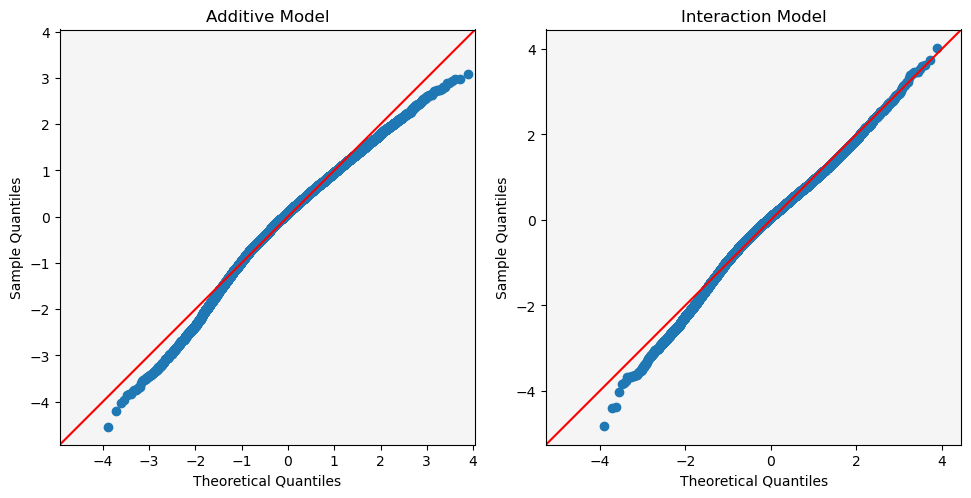

In [131]:
## Normal qqplots

fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,5)
fig.tight_layout(pad=2.0)

resid_m1 = np.log(y1_train_pred)-y_train
sm.qqplot(resid_m1/np.std(resid_m1), line='45', ax=axs[0])
axs[0].set_title('Additive Model')

resid_m_poly2 = np.log(y2poly_train_pred)-y_train
sm.qqplot(resid_m_poly2/np.std(resid_m_poly2), line='45', ax=axs[1])
axs[1].set_title('Interaction Model')

Text(0, 1000, '94.5% actual within interval')

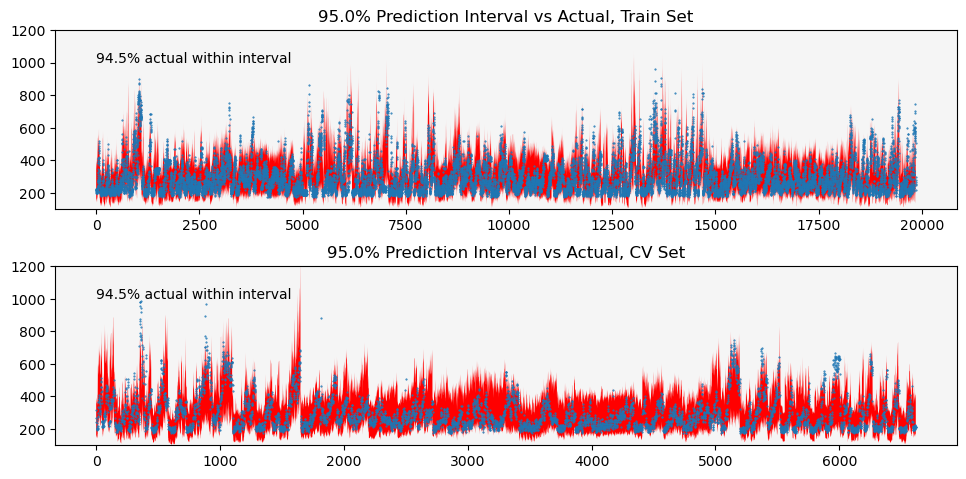

In [87]:
## Prediction Interval vs Actual Data

fig, axs = plt.subplots(2,1)
fig.set_size_inches(10,5)
fig.tight_layout(pad=2.0)

a = 0.05 # alpha level

y_test_pred = m_poly2.get_prediction(X_test_poly2).summary_frame(alpha=a)
y_train_pred = m_poly2.get_prediction(X_train_poly2).summary_frame(alpha=a)

y_test_upper = np.exp(y_test_pred['obs_ci_upper'])
y_test_p50 = np.exp(y_test_pred['mean'])
y_test_lower = np.exp(y_test_pred['obs_ci_lower'])

y_train_upper = np.exp(y_train_pred['obs_ci_upper'])
y_train_p50 = np.exp(y_train_pred['mean'])
y_train_lower = np.exp(y_train_pred['obs_ci_lower'])

axs[0].fill_between(range(len(y_train_p50)), y_train_upper, y_train_lower, facecolor='red')
axs[0].scatter(range(len(y_train_p50)), np.exp(y_train), marker='.', s=1)
axs[0].set_ylim((100,1200))
axs[0].set_title(str(100*(1-a)) + '% Prediction Interval vs Actual, Train Set')

axs[1].fill_between(range(len(y_test_p50)), y_test_upper, y_test_lower, facecolor='red')
axs[1].scatter(range(len(y_test_p50)), np.exp(y_test), marker='.', s=1)
axs[1].set_ylim((100,1200))
axs[1].set_title(str(100*(1-a)) + '% Prediction Interval vs Actual, CV Set')

## Percent outside
train_p = 100*(1-(np.sum((np.exp(y_train) > y_train_upper)) + np.sum((np.exp(y_train) < y_train_lower)))/len(y_train))
test_p = 100*(1-(np.sum((np.exp(y_test) > y_test_upper)) + np.sum((np.exp(y_test) < y_test_lower)))/len(y_test))

axs[0].text(0,1000, "{:.1f}".format(train_p) + '% actual within interval')
axs[1].text(0,1000, "{:.1f}".format(test_p) + '% actual within interval')

Text(0.5, 1.0, 'Electricity Consumption Prediction for Test Data')

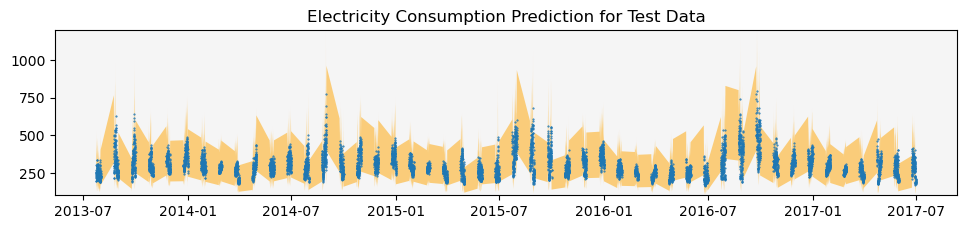

In [88]:
# Test set final predictions

y_final_pred = m_poly2.get_prediction(X_applied_poly2).summary_frame(alpha=a)

y_final_upper = np.exp(y_final_pred['obs_ci_upper'])
y_final_p50 = np.exp(y_final_pred['mean'])
y_final_lower = np.exp(y_final_pred['obs_ci_lower'])

fig, ax = plt.subplots()
fig.set_size_inches(10,2.5)
fig.tight_layout(pad=2.0)

ax.fill_between(pd.to_datetime(test['datetime'][idx_test_set]), y_final_upper, y_final_lower, 
                facecolor='orange', alpha=0.5)
ax.scatter(pd.to_datetime(test['datetime'][idx_test_set]), y_final_p50, marker='.', s=1)
ax.set_ylim((100,1200))
ax.set_title('Electricity Consumption Prediction for Test Data')


In [89]:
## Add final predictions to test data

test.loc[idx_test_set,'electricity_consumption'] = y_final_p50
test.loc[idx_test_set,'ec_lower'] = y_final_lower
test.loc[idx_test_set,'ec_upper'] = y_final_upper

test.to_csv('./results.csv')


In [122]:
## Since the larger, more complex model performs better, let's try a neural network approach next
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(600,),activation='relu',solver='adam',alpha=0.01, batch_size=200, 
                    learning_rate='adaptive', learning_rate_init=0.0001,max_iter=100000, random_state=1024)

## Collect input features into array
X_nn = np.array(train[['var1','ws','temperature','pressure']])
y_nn = np.array(train['ec'])
X_applied_nn = np.array(test[['var1','ws','temperature','pressure']])

## One hot encoding for categorical variables var2, hour, and month
enc = OneHotEncoder(drop='first')
for c in ['var2','month','hour']:
    enc.fit(train[c].to_numpy().reshape(-1, 1))
    X_nn = np.concatenate((X_nn,enc.transform(train[c].to_numpy().reshape(-1,1)).toarray()), axis=1)
    enc.fit(test[c].to_numpy().reshape(-1, 1))
    X_applied_nn = np.concatenate((X_applied_nn,enc.transform(test[c].to_numpy().reshape(-1,1)).toarray()), axis=1)

## Remove nan rows 
idx = ~np.isnan(np.concatenate((y_nn.reshape(-1, 1), X_nn), axis=1)).any(axis=1)
X_nn = X_nn[idx,]
y_nn = y_nn[idx,]
idx_test_set = ~np.isnan(X_applied_nn).any(axis=1)
X_applied_nn = X_applied_nn[idx_test_set,]
X_train_nn = np.concatenate((X_nn,poly.fit_transform(X_nn)), axis=1)
X_test_nn = np.concatenate((X_test,poly.fit_transform(X_test)), axis=1)
X_applied_nn = np.concatenate((X_applied_nn,poly.fit_transform(X_applied_nn)), axis=1)

## Train-test split for training/testing model
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size = 0.25, shuffle=False)

m_nn = mlp.fit(X_train_nn, y_train_nn)

In [123]:
## Train RMSE
y_pred_nn = m_nn.predict(X_test_nn)
y_train_pred_nn = m_nn.predict(X_train_nn)
rmse(np.exp(y_train_nn),np.exp(y_train_pred_nn))

81.90811606973863

In [124]:
## Test RMSE
rmse(np.exp(y_test_nn),np.exp(y_pred_nn))

83.87594279367659

In [126]:
# Model stat comparison
rmses

Train       Test       R^2
add_mod_1  82.933452  84.961849  0.413154
add_mod_2  83.098063  85.099927  0.411033
add_mod_3  66.361861  86.608404  0.469575
int_mod_1  77.768747  80.584348  0.483685
int_mod_2  77.768751  80.584288  0.483685
int_mod_3  68.097495  81.041162  0.529235